In [3]:
import gc
import datetime
import functools
import os
import random
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [6]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [7]:
_, data_info = tfds.load("cars196", with_info=True)
num_examples_train = data_info.splits["train"].num_examples
num_examples_test = data_info.splits["test"].num_examples
total_num_classes = data_info.features["label"].num_classes

In [8]:
training_classes = total_num_classes // 1
examples_per_class_per_batch = 5
train_cls = random.sample(range(total_num_classes), k=training_classes)
batch_size = 80
classes_per_batch = batch_size // examples_per_class_per_batch  # 16 classes per batch
origin_img_size = 256
target_img_size = 224
area_range = [0.16, 1.0]
# preprocessing function that resizes images to ensure all images are the same shape
pxl_mean = tf.constant(-np.array([0.485, 0.456, 0.406]), dtype=tf.float32)
pxl_std = tf.constant(np.array([0.229, 0.224, 0.225]), dtype=tf.float32)

print(f"Class IDs seen during training {train_cls}")


def preprocess(img, y, *args, origin_size):
    with tf.device("/cpu:0"):
        img = tf.keras.layers.Resizing(origin_size, origin_size, crop_to_aspect_ratio=True)(img)
        # 'RGB'->'BGR'
        img = img[..., ::-1]
        # normalize_transform
        img /= 255.0
        img = tf.nn.bias_add(img, pxl_mean, data_format=None)
        img /= pxl_std

    return img, y


def train_augmentation(img_batch, y, *args, target_size, area_range):
    # create random crops
    num_imgs = tf.shape(img_batch)[0]
    crop_area = tf.random.uniform(shape=(num_imgs,1), minval=0.15, maxval=1.)
    start_y = tf.random.uniform(shape=(num_imgs, 1), minval=0., maxval=1-crop_area)
    start_x = tf.random.uniform(shape=(num_imgs, 1), minval=0., maxval=1-crop_area)
    start_yx = tf.concat((start_y, start_x), axis=1)
    end_yx = start_yx+crop_area
    boxes = tf.concat((start_yx,end_yx), axis=1)
    box_indicies = tf.range(num_imgs)
    
    # random crop
    img_batch = tf.image.crop_and_resize(img_batch, boxes, box_indicies, (target_size, target_size))
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)

    return img_batch, y



def test_augmentation(img_batch, y, *args, origin_size, target_size):
    img_batch = tf.image.central_crop(img_batch, target_size / origin_size)
    img_batch = tf.keras.layers.Resizing(target_size, target_size, crop_to_aspect_ratio=True)(img_batch)

    return img_batch, y


# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="train",
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
    class_list=train_cls,
    augmenter=functools.partial(
        train_augmentation,
        target_size=target_img_size,
        area_range=area_range,
    ),
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="test",
    total_examples_per_class=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
    augmenter=functools.partial(
        test_augmentation,
        origin_size=origin_img_size,
        target_size=target_img_size,
    ),
)

Class IDs seen during training [99, 166, 87, 159, 65, 157, 88, 141, 115, 21, 3, 147, 51, 26, 15, 136, 46, 34, 80, 192, 33, 148, 168, 63, 123, 43, 167, 58, 4, 30, 66, 18, 112, 20, 103, 171, 97, 175, 190, 83, 94, 59, 5, 179, 39, 122, 144, 142, 153, 72, 14, 161, 139, 110, 1, 67, 35, 138, 137, 169, 156, 107, 85, 62, 24, 113, 191, 32, 195, 104, 127, 17, 54, 117, 194, 163, 52, 155, 81, 101, 146, 164, 2, 70, 134, 143, 121, 154, 180, 177, 16, 151, 8, 69, 120, 165, 118, 189, 176, 149, 152, 50, 37, 42, 126, 174, 82, 71, 150, 181, 74, 111, 36, 44, 100, 68, 128, 19, 49, 0, 38, 28, 186, 40, 133, 105, 172, 109, 119, 188, 73, 22, 86, 170, 12, 13, 6, 158, 64, 106, 145, 27, 98, 75, 108, 76, 162, 135, 9, 77, 61, 31, 55, 140, 193, 130, 131, 93, 125, 92, 41, 184, 79, 7, 91, 187, 23, 96, 185, 45, 89, 129, 84, 25, 10, 47, 60, 132, 182, 178, 173, 116, 95, 102, 160, 124, 29, 11, 78, 57, 56, 90, 48, 53, 114, 183]


converting train:   0%|          | 0/8144 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8144 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8144 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/196 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8144 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/8144 [00:00<?, ?it/s]

converting test:   0%|          | 0/8041 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8041 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8041 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/196 [00:00<?, ?it/s]

gather examples:   0%|          | 0/980 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/980 [00:00<?, ?it/s]

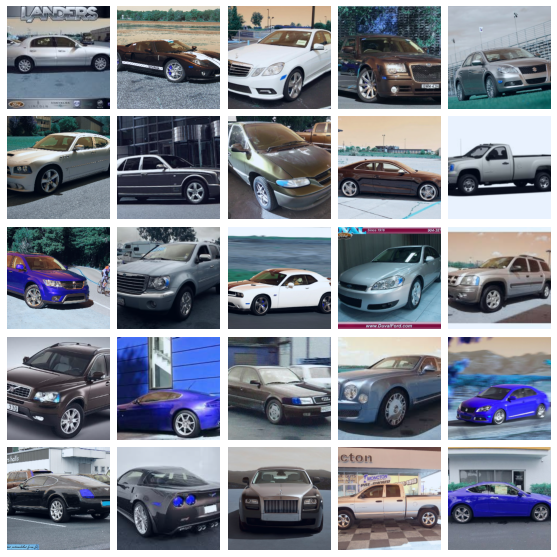

In [9]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

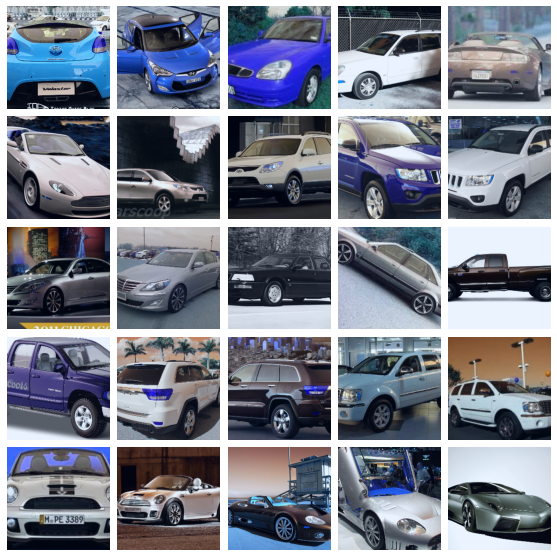

In [10]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = test_ds.generate_batch(0)
x_slice = x_batch[0:num_cols*num_rows]
y_slice = y_batch[0:num_cols*num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

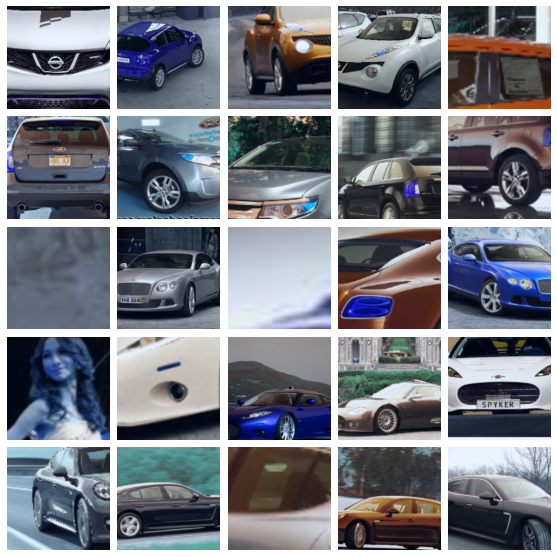

In [11]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = train_ds.generate_batch(0)
x_slice = x_batch[0:num_cols*num_rows]
y_slice = y_batch[0:num_cols*num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

In [12]:
num_targets = 200
num_queries = 300
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, num_queries)
targets_x, targets_y = test_ds.get_slice(num_queries, num_targets)

queries_x, queries_y = test_augmentation(queries_x, queries_y, origin_size=origin_img_size, target_size=target_img_size,)
targets_x, targets_y = test_augmentation(targets_x, targets_y, origin_size=origin_img_size, target_size=target_img_size,)
    
# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    # known_classes=tf.constant(train_cls),
    k=k,
)

logdir = os.path.join("logs_cars", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tbc = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    val_loss,
    tbc,
]

logs_cars/20220422-001550


In [13]:
embedding_size = 512

# building model
model = tfsim.architectures.ResNet50Sim(
    (target_img_size, target_img_size, 3),
    embedding_size,
    trainable="full",
    pooling="avg",  # Can change to use `gem` -> GeneralizedMeanPooling2D
    # gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

In [ ]:
epochs = 500
LR = 0.00003
WD = 0.0005
steps_per_epoch = num_examples_train // batch_size
val_steps = 50


# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(distance=distance, alpha=2.0, beta=50.0, epsilon=0.1, lmda=1.0, center=1.0)
# optimizer = tfa.optimizers.AdamW(
#     weight_decay=WD,
#     learning_rate=LR
# )
optimizer = tf.keras.optimizers.Adam(LR)


# compiling and training
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/500


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


  6/101 [>.............................] - ETA: 40s - loss: 1.2559WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1760s vs `on_train_batch_end` time: 0.2247s). Check your callbacks.


101/101 [==============================] - ETA: 0s - loss: 0.9491Warmup complete
f1: 0.0519 - binary_accuracy: 0.0267
101/101 [==============================] - 64s 518ms/step - loss: 0.9491 - val_loss: 0.4044 - f1: 0.0519 - binary_accuracy: 0.0267
Warmup complete
Epoch 2/500
101/101 [==============================] - 50s 498ms/step - loss: 0.8823 - val_loss: 0.4002 - f1: 0.0456 - binary_accuracy: 0.0233
Epoch 3/500
101/101 [==============================] - 50s 498ms/step - loss: 0.8796 - val_loss: 0.3979 - f1: 0.0707 - binary_accuracy: 0.0367
Epoch 4/500
101/101 [==============================] - 50s 498ms/step - loss: 0.8774 - val_loss: 0.3932 - f1: 0.0952 - binary_accuracy: 0.0500
Epoch 5/500
101/101 [==============================] - 50s 497ms/step - loss: 0.8759 - val_loss: 0.3881 - f1: 0.1424 - binary_accuracy: 0.0767
Epoch 6/500
101/101 [==============================] - 50s 498ms/step - loss: 0.8741 - val_loss: 0.3844 - f1: 0.1873 - binary_accuracy: 0.1033
Epoch 7/500
101/101 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



101/101 [==============================] - 50s 494ms/step - loss: 0.8373 - val_loss: 0.3453 - f1: 0.5577 - binary_accuracy: 0.3867
Epoch 193/500
101/101 [==============================] - 49s 487ms/step - loss: 0.8380 - val_loss: 0.3474 - f1: 0.5366 - binary_accuracy: 0.3667
Epoch 194/500
101/101 [==============================] - 50s 492ms/step - loss: 0.8377 - val_loss: 0.3444 - f1: 0.5401 - binary_accuracy: 0.3700
Epoch 195/500
101/101 [==============================] - 50s 492ms/step - loss: 0.8381 - val_loss: 0.3470 - f1: 0.5366 - binary_accuracy: 0.3667
Epoch 196/500
101/101 [==============================] - 50s 496ms/step - loss: 0.8370 - val_loss: 0.3446 - f1: 0.5542 - binary_accuracy: 0.3833
Epoch 197/500
101/101 [==============================] - 49s 487ms/step - loss: 0.8370 - val_loss: 0.3491 - f1: 0.5149 - binary_accuracy: 0.3467
Epoch 198/500
101/101 [==============================] - 49s 487ms/step - loss: 0.8359 - val_loss: 0.3483 - f1: 0.5330 - binary_accuracy: 0.3633

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



101/101 [==============================] - 49s 488ms/step - loss: 0.8325 - val_loss: 0.3415 - f1: 0.5782 - binary_accuracy: 0.4067
Epoch 300/500
101/101 [==============================] - 50s 491ms/step - loss: 0.8328 - val_loss: 0.3447 - f1: 0.5849 - binary_accuracy: 0.4133
Epoch 301/500
101/101 [==============================] - 49s 488ms/step - loss: 0.8322 - val_loss: 0.3356 - f1: 0.5748 - binary_accuracy: 0.4033
Epoch 302/500
101/101 [==============================] - 50s 491ms/step - loss: 0.8318 - val_loss: 0.3355 - f1: 0.5849 - binary_accuracy: 0.4133
Epoch 303/500
101/101 [==============================] - 49s 487ms/step - loss: 0.8329 - val_loss: 0.3381 - f1: 0.5782 - binary_accuracy: 0.4067
Epoch 304/500
101/101 [==============================] - 49s 488ms/step - loss: 0.8319 - val_loss: 0.3423 - f1: 0.5816 - binary_accuracy: 0.4100
Epoch 305/500
101/101 [==============================] - 50s 496ms/step - loss: 0.8332 - val_loss: 0.3428 - f1: 0.5882 - binary_accuracy: 0.4167

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

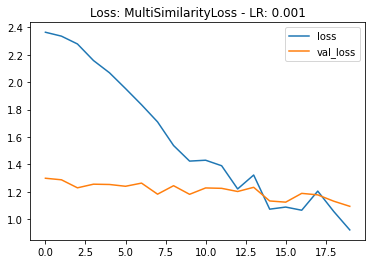

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()